# Merge of datasets: Dyspnea, Vaccination, Act_disaggregated

In [23]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
#import geopandas as gpd
import omnivida_loader as ov
import omnivida_util as ou
import statsmodels.api         as sm
import statsmodels.formula.api as smf
%matplotlib inline

In [24]:
adherence, adherence_change = ov.get_adherence_dataset()
dyspnea = ov.get_dyspnea_dataset()
act_disag = ov.get_act_disag_dataset()
act = ov.get_act_dataset()

In [25]:
act_disag.drop(columns=['Unnamed: 0'], axis = 1, inplace=True)
dyspnea.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)
act.drop(columns=['Unnamed: 0'], axis = 1, inplace = True)

## Dataset de dyspnea

In [26]:
dyspnea

,id_patient,discharge_date,medical_test
0,1998401,2016-06-02,0
1,1491934,2016-06-10,0
2,801004,2019-07-12,0
3,1226479,2019-07-26,0
4,1241688,2016-09-01,0
...,...,...,...
132,1690591,2016-03-08,4
133,1690591,2016-06-01,4
134,1718360,2016-12-13,4
135,1718360,2018-03-20,4


In [27]:
dyspnea.dtypes

id_patient                 int64
discharge_date    datetime64[ns]
medical_test               int64
dtype: object

In [28]:
dyspnea_cp = dyspnea.copy()
dyspnea_cp['discharge_month'] = dyspnea_cp['discharge_date'].dt.month
dyspnea_cp['discharge_year'] = dyspnea_cp['discharge_date'].dt.year
dyspnea_cp_control = pd.pivot_table(dyspnea_cp, values='medical_test', index='discharge_month', columns='discharge_year', aggfunc='mean')

Text(0.5, 1, 'Scoring in medical test')

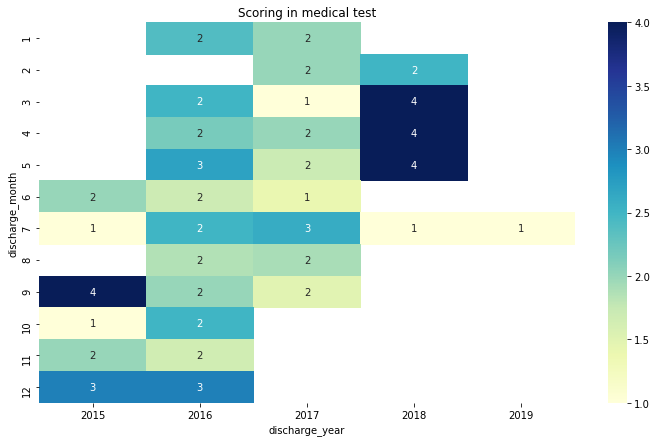

In [29]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(dyspnea_cp_control, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Scoring in medical test')

In [30]:
adherence_change.dtypes

id_patient                               int64
survey_date                     datetime64[ns]
morisky_green                          float64
smaq1                                  float64
smaq2                                  float64
espa                                   float64
nm_espa                                float64
qualitative_result                     float64
quantitative_result                    float64
category                              category
morisky_change                         float64
smaq1_change                           float64
smaq2_change                           float64
espa_change                            float64
nm_espa_change                         float64
qualitative_result_change              float64
quantitative_result_change             float64
days_since_last_control                float64
num_reports                              int64
ongoing_adherence_percentage           float64
dtype: object

In [31]:
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'quantitative_result', 'qualitative_result_change', 'quantitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage']
adherence_change_analysis = adherence_change[select_fields]
adherence_change_analysis.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
0,500547,2016-07-11,A,1.0,4.0,NaN,NaN,NaN,100.0
1,500547,2019-03-14,A,1.0,4.0,0.0,0.0,976.0,100.0
2,500547,2019-10-11,A,1.0,4.0,0.0,0.0,211.0,100.0
3,500547,2019-12-09,A,1.0,4.0,0.0,0.0,59.0,100.0
4,500547,2020-01-16,A,1.0,4.0,0.0,0.0,38.0,100.0
5,500547,2020-03-25,A,1.0,4.0,0.0,0.0,69.0,100.0
6,500547,2020-05-08,A,1.0,4.0,0.0,0.0,44.0,100.0
7,500588,2019-04-26,A,1.0,4.0,NaN,NaN,NaN,100.0
8,502989,2014-08-22,M,0.0,2.0,NaN,NaN,NaN,0.0
9,502989,2014-10-28,M,0.0,2.0,0.0,0.0,67.0,0.0


In [32]:
dysp = dyspnea.copy()
N_Records_Per_Patient = dysp.groupby('id_patient').size().reset_index(name='N_Records')
N_Records_Per_Patient.head(5)

,id_patient,N_Records
0,524006,5
1,540333,1
2,604083,1
3,622031,3
4,664340,1


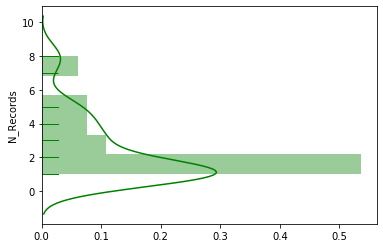

In [33]:
from scipy.stats import norm
sns.distplot(N_Records_Per_Patient['N_Records'], rug = True, vertical = True, color = "green")

In [34]:
num_records_per_category = adherence.groupby('category').size().sort_values(ascending=True).reset_index(name='count_records')

num_records_per_category


,category,count_records
0,N,10
1,N+,472
2,A-,689
3,M,1285
4,A,2317


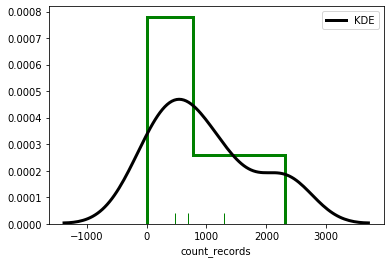

In [35]:
sns.distplot(num_records_per_category['count_records'], rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [36]:
print("N. Pacientes - dataset Adher: ", adherence.groupby('id_patient').count().shape[0])

N. Pacientes - dataset Adher:  840


In [37]:
dyspnea_adher = adherence.merge(dysp, how = "left", on = "id_patient" )
dyspnea_adher.dtypes

id_patient                      int64
survey_date            datetime64[ns]
morisky_green                 float64
smaq1                         float64
smaq2                         float64
espa                          float64
nm_espa                       float64
qualitative_result            float64
quantitative_result           float64
category                     category
discharge_date         datetime64[ns]
medical_test                  float64
dtype: object

## Dataset de act_desagregado

In [38]:
act_disag.dtypes

id_patient              int64
survey_name            object
result_date    datetime64[ns]
A_ACT                  object
B_ACT                  object
C_ACT                  object
D_ACT                  object
FEEDBACK               object
dtype: object

In [39]:
act_disag

,id_patient,survey_name,result_date,A_ACT,B_ACT,C_ACT,D_ACT,FEEDBACK
0,535255,Prueba de control del Asma ACT,2012-06-29,NaN,NaN,POCAS VECES,NaN,NaN
1,535255,Prueba de control del Asma ACT,2012-06-29,NaN,1 O 2 VECES A LA SEMANA,NaN,NaN,NaN
2,535255,Prueba de control del Asma ACT,2012-06-29,DE 2 A 3 NOCHES EN A LA SEMANA,NaN,NaN,NaN,NaN
3,535255,Prueba de control del Asma ACT,2012-06-29,NaN,NaN,NaN,1 VEZ A LA SEMANA O MENOS,NaN
4,535255,Prueba de control del Asma ACT,2012-06-29,NaN,NaN,NaN,NaN,BIEN CONTROLADA
...,...,...,...,...,...,...,...,...
8570,744564,Prueba de control del Asma ACT,2020-05-20,NaN,NaN,POCAS VECES,NaN,NaN
8571,744564,Prueba de control del Asma ACT,2020-05-20,NaN,1 O 2 VECES A LA SEMANA,NaN,NaN,NaN
8572,744564,Prueba de control del Asma ACT,2020-05-20,NUNCA,NaN,NaN,NaN,NaN
8573,744564,Prueba de control del Asma ACT,2020-05-20,NaN,NaN,NaN,1 VEZ A LA SEMANA O MENOS,NaN


In [40]:
act_disag_cp = act_disag.copy()
act_total = act_disag_cp.merge(act, how='left', on = 'id_patient')

In [41]:
act_total_date = ou.merge_on_closest_date(df1=act_disag_cp, df2=act, date_field_df1= 'result_date',date_field_df2 = 'date_result', merge_on='id_patient')

In [44]:
act_total_date

,id_patient,survey_name,result_date,A_ACT,B_ACT,C_ACT,D_ACT,FEEDBACK,days_since_date_result,act_score,result,date_result
0,788432,Prueba de control del Asma ACT,2014-07-17,NaN,NaN,NUNCA,NaN,NaN,146.589745,19,0,2014-02-20 09:50:46
1,788432,Prueba de control del Asma ACT,2014-07-17,NaN,NaN,NUNCA,NaN,NaN,146.589745,19,0,2014-02-20 09:50:46
2,788432,Prueba de control del Asma ACT,2014-07-17,NaN,NaN,NUNCA,NaN,NaN,146.589745,19,0,2014-02-20 09:50:46
3,788432,Prueba de control del Asma ACT,2014-07-17,NaN,NaN,NUNCA,NaN,NaN,146.589745,19,0,2014-02-20 09:50:46
4,788432,Prueba de control del Asma ACT,2014-07-17,NaN,NaN,NUNCA,NaN,NaN,146.589745,19,0,2014-02-20 09:50:46
...,...,...,...,...,...,...,...,...,...,...,...,...
59140,1277338,Prueba de control del Asma ACT,2020-05-08,DE 2 A 3 NOCHES EN A LA SEMANA,NaN,NaN,NaN,NaN,189.508808,18,0,2019-10-31 11:47:19
59141,1277338,Prueba de control del Asma ACT,2020-05-08,NaN,NaN,NaN,MAS DE 3 VECES AL DIA,NaN,189.508808,18,0,2019-10-31 11:47:19
59142,1277338,Prueba de control del Asma ACT,2020-05-08,NaN,NaN,NaN,MAS DE 3 VECES AL DIA,NaN,189.508808,18,0,2019-10-31 11:47:19
59143,1277338,Prueba de control del Asma ACT,2020-05-08,NaN,NaN,NaN,NaN,ALGO CONTROLADA,189.508808,18,0,2019-10-31 11:47:19


In [65]:
act_total_date.groupby('result',as_index=False).count()

,result,id_patient,survey_name,result_date,A_ACT,B_ACT,C_ACT,D_ACT,FEEDBACK,days_since_date_result,act_score,date_result,months_resuls,year_resuls
0,0,28035,28035,28035,5607,5607,5607,5607,5607,28035,28035,28035,28035,28035
1,1,24720,24720,24720,4944,4944,4944,4944,4944,24720,24720,24720,24720,24720
2,2,6390,6390,6390,1278,1278,1278,1278,1278,6390,6390,6390,6390,6390


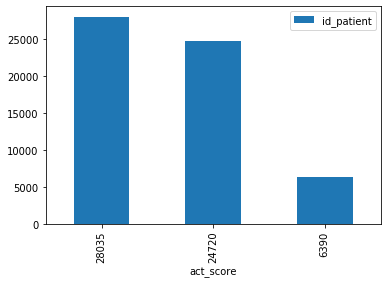

In [67]:
new_fields = ['id_patient', 'act_score', 'result']
act_total_date_filtered = act_total_date[new_fields]

act_control_results = act_total_date_filtered.groupby('result').count()
act_control_results.plot(kind='bar', x='act_score')

#### 6390   records tagged as 2 - NO está controlado
#### 24,720 records tagged as 1 - NO totalmente controlada
#### 28,035 records tagged as 0 - Totalmente controlada

In [76]:
scoring_analitics = act_total_date.groupby('act_score', as_index=False).count()
scoring_analitics.describe()

<bound method DataFrame.info of     act_score  id_patient  survey_name  result_date  A_ACT  B_ACT  C_ACT  \
0           5         675          675          675    135    135    135   
1           6         700          700          700    140    140    140   
2           7        1175         1175         1175    235    235    235   
3           8        1060         1060         1060    212    212    212   
4           9        1395         1395         1395    279    279    279   
5          10        1230         1230         1230    246    246    246   
6          11        1360         1360         1360    272    272    272   
7          12        1410         1410         1410    282    282    282   
8          13        1810         1810         1810    362    362    362   
9          14        1910         1910         1910    382    382    382   
10         15        2335         2335         2335    467    467    467   
11         16        2185         2185         2185    4

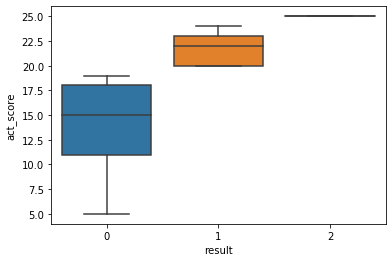

In [75]:
sns.boxplot(x = 'result', y = 'act_score', data= act_total_date)

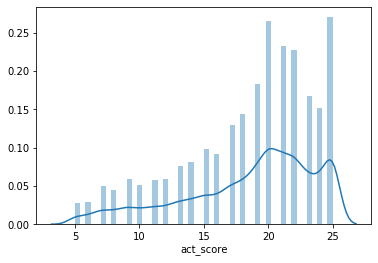

In [51]:
sns.distplot(act_total_date['act_score'])
plt.title('Results during ACT test')

In [47]:
act_total_date['months_resuls'] = act_total_date['result_date'].dt.month
act_total_date['year_resuls'] = act_total_date['result_date'].dt.year
act_control = pd.pivot_table(act_total_date, values='act_score', index='months_resuls', columns='year_resuls', aggfunc='mean')

Text(0.5, 1, 'Scoring during ACT Test')

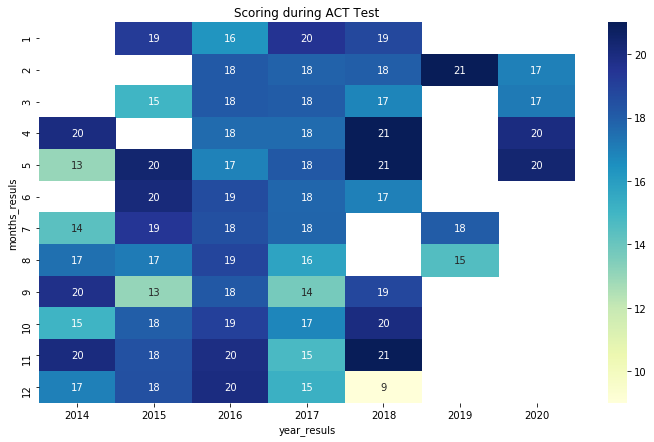

In [52]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(act_control, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Scoring during ACT Test')